In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

sample_submission = pd.read_csv('../input/sf-dl-person-segmentation/sample-submission.csv')
image_paths_list = '/kaggle/input/coco2017/val2017/' + sample_submission.ImageId
image_paths_list

0       /kaggle/input/coco2017/val2017/val2017/0000005...
1       /kaggle/input/coco2017/val2017/val2017/0000004...
2       /kaggle/input/coco2017/val2017/val2017/0000003...
3       /kaggle/input/coco2017/val2017/val2017/0000003...
4       /kaggle/input/coco2017/val2017/val2017/0000003...
                              ...                        
2688    /kaggle/input/coco2017/val2017/val2017/0000002...
2689    /kaggle/input/coco2017/val2017/val2017/0000000...
2690    /kaggle/input/coco2017/val2017/val2017/0000004...
2691    /kaggle/input/coco2017/val2017/val2017/0000000...
2692    /kaggle/input/coco2017/val2017/val2017/0000004...
Name: ImageId, Length: 2693, dtype: object

In [2]:
import mxnet as mx
from mxnet import image
from mxnet.gluon.data.vision import transforms
from gluoncv.data.transforms.presets.segmentation import test_transform
import gluoncv
from gluoncv.utils.viz import get_color_pallete
import matplotlib.image as mpimg
# using cpu
ctx = mx.gpu(0)

In [3]:
#другие модели можно найти с помощью gluoncv.model_zoo.get_model_list()
models = {
    'fcn_resnet101_coco': {'prediction_codes': 'pascal_voc'},
    'fcn_resnet101_voc': {'prediction_codes': 'pascal_voc'},
    'fcn_resnet101_ade': {'prediction_codes': 'ade20k'},
    
    'psp_resnet101_coco': {'prediction_codes': 'pascal_voc'},
    'psp_resnet101_voc': {'prediction_codes': 'pascal_voc'},
    'psp_resnet101_ade': {'prediction_codes': 'ade20k'},
    
    'deeplab_resnet101_coco': {'prediction_codes': 'pascal_voc'},
    'deeplab_resnet101_voc': {'prediction_codes': 'pascal_voc'},
    'deeplab_resnet101_ade': {'prediction_codes': 'ade20k'},
    
    'deeplab_resnet152_coco': {'prediction_codes': 'pascal_voc'},
    'deeplab_resnet152_voc': {'prediction_codes': 'pascal_voc'},
}

for model_name, model_info in models.items():
    model_info['model'] = gluoncv.model_zoo.get_model(model_name, pretrained=True, ctx=ctx)

person_indices = {
    'pascal_voc': 15,
    'ade20k': 12
}

100121KB [00:03, 28640.03KB/s]                           


100%|██████████| 197325/197325 [00:06<00:00, 32885.42KB/s]


197333KB [00:06, 29584.32KB/s]                            


197770KB [00:06, 30347.98KB/s]                            


self.crop_size 480


100%|██████████| 266385/266385 [00:07<00:00, 33739.00KB/s]


self.crop_size 480


100%|██████████| 266385/266385 [00:07<00:00, 34300.91KB/s]


self.crop_size 480


100%|██████████| 266773/266773 [00:08<00:00, 32193.51KB/s]


100%|██████████| 221704/221704 [00:07<00:00, 28054.22KB/s]


221696KB [00:06, 35794.87KB/s]                            


100%|██████████| 221969/221969 [00:06<00:00, 35116.65KB/s]


279271KB [00:08, 34711.18KB/s]                            


100%|██████████| 279263/279263 [00:08<00:00, 32133.80KB/s]


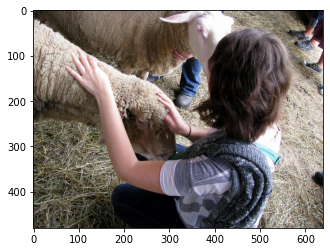

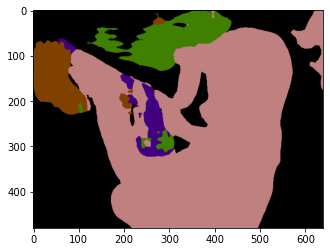

In [4]:
def get_all_predictions(img_orig, model_name):
    img = mx.nd.array(img_orig)
    img = test_transform(img, ctx)
    model_info = models[model_name]
    output = model_info['model'].predict(img)
    predict = mx.nd.squeeze(mx.nd.argmax(output, 1)).asnumpy()
    predict = get_color_pallete(predict, model_info['prediction_codes'])
    return predict

image = np.array(Image.open(image_paths_list[1]))
plt.imshow(image)
plt.show()

predict = get_all_predictions(image, 'fcn_resnet101_coco')
plt.imshow(predict)
plt.show()

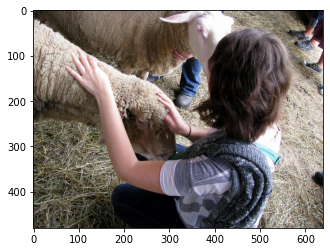

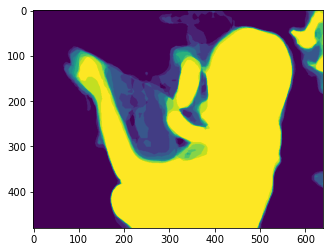

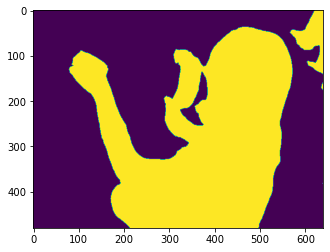

In [5]:
def get_mask(img_orig, threshold = None):
    img = mx.nd.array(img_orig)
    img = test_transform(img, ctx)
    masks = []
    for model_name, model_info in models.items():
        model = model_info['model']
        person_idx = person_indices[model_info['prediction_codes']]
        output = model.predict(img)
        predict = mx.nd.squeeze(mx.nd.argmax(output, 1)).asnumpy()
        predict = (predict == person_idx).astype(int)
        masks.append(predict)
    mask = np.mean(np.array(masks), axis = 0)
    if threshold is not None:
        mask = np.where(mask > threshold, 1, 0)
    return mask

image = np.array(Image.open(image_paths_list[1]))
plt.imshow(image)
plt.show()

mask = get_mask(image)
plt.imshow(mask)
plt.show()

mask = get_mask(image, threshold = 0.4)
plt.imshow(mask)
plt.show()

In [6]:
predictions = []
from tqdm.notebook import tqdm
for path in tqdm(image_paths_list):
    image = np.array(Image.open(path).convert('RGB')) #есть ч-б изображения
    predictions.append(get_mask(image, threshold = 0.4))

In [7]:
# кодирование маски в EncodedPixels
def mask_to_rle(mask):
    mask_flat = mask.flatten('F')
    flag = 0
    rle_list = list()
    for i in range(mask_flat.shape[0]):
        if flag == 0:
            if mask_flat[i] == 1:
                flag = 1
                starts = i+1
                rle_list.append(starts)
        else:
            if mask_flat[i] == 0:
                flag = 0
                ends = i
                rle_list.append(ends-starts+1)
    if flag == 1:
        ends = mask_flat.shape[0]
        rle_list.append(ends-starts+1)
    #sanity check
    if len(rle_list) % 2 != 0:
        print('NG')
    if len(rle_list) == 0:
        rle = np.nan
    else:
        rle = ' '.join(map(str,rle_list))
    return rle

predictions_encoded = [mask_to_rle(mask) for mask in tqdm(predictions)]
sample_submission['EncodedPixels'] = predictions_encoded
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head()

,ImageId,EncodedPixels
0,val2017/000000532481.jpg,116925 3 117347 10 117773 11 118200 12 118627 ...
1,val2017/000000458755.jpg,38051 1 38528 7 39007 12 39486 14 39965 16 404...
2,val2017/000000385029.jpg,400 81 879 82 1359 82 1838 83 2318 83 2798 83 ...
3,val2017/000000311303.jpg,25202 1 25627 4 26053 6 26479 8 26905 9 27331 ...
4,val2017/000000393226.jpg,44965 10 45442 13 45918 17 46395 20 46873 23 4...
